<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/Intel_Image_Classification3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Need v1.0.25 of fastai which is not yet published so install it from GitHub.

In [0]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
#!pip install tensorflow==1.2

# For the latest nightly build:
#!pip install tf-nightly


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai
!pip install torchtext==0.2.3
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

In [4]:
import torch
print(torch.__version__)


1.0.0


In [0]:
from fastai import *
from fastai.vision import *
import pandas as pd 

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
#bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

#  Intel Scene Classification Image Dataset

## Looking at the data

###Getting Dataset from Kaggle

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"navneetkrch","key":"4910f3543e9486158ccfa00ca84b274f"}'> ~/.kaggle/kaggle.json  # Replace
!chmod 600 kaggle.json


In [0]:
!mkdir -p data
!mkdir -p data/test
!kaggle datasets download -d nitishabharathi/scene-classification

In [0]:
!unzip scene-classification.zip 

In [0]:
!unzip train-scene\ classification.zip -d data/
!mv test_WyRytb0.csv data/test.csv
!mv data/train.csv data/train/labels.csv

In [22]:
print("all files unzipped. Images in train folder and labels in test.csv")

all files unzipped. Images in train folder and labels in test.csv


### Separate the Test Files in a separate Test Folder

In [23]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

,image_name
0,3.jpg
1,5.jpg
2,6.jpg
3,11.jpg
4,14.jpg


In [0]:
test_df.to_csv("out.csv", index=False,header=False) ## create the csv file without the Headers

#Just the header has been removed from the test labels for the below cell to run correctly
#test_df2 = pd.read_csv('out.csv')
#test_df2.head()
!rsync --files-from=out.csv data/train data/test


In [25]:
print("Now we have separated the Test files from Train and put in Test Folder itself")

Now we have separated the Test files from Train and put in Test Folder itself


###Setting the path for data

We are going to use the [Intel Image Scene](https://www.kaggle.com/nitishabharathi/scene-classification) by [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-intel-scene-classification-challe/) which features 6 scenes.

Our model will need to learn to differentiate between these 6 distinct categories. 
We use **FASTAI-V1** model to get the results.

####DATASET DESCRIPTION
**There are 17034 images in train and 7301 images in test data.**

The categories of natural scenes and their corresponding labels in the dataset are as follows -

 ** 'buildings' -> 0,**

**'forest' -> 1,** 

**'glacier' -> 2,**

**'mountain' -> 3,**

**'sea' -> 4, **

**'street' -> 5 **

There are three files provided to you, viz **train.zip, test.csv and sample_submission.csv** which have the following structure.

Variable	Definition

image_name	Name of the image in the dataset (ID column)

label	Category of natural scene (target column)

**train.zip contains the images corresponding to both train and test set along with the true labels for train set images in train.csv**

In [26]:
path = 'data';path

'data'

In [0]:
path_img = 'data/train'

In [28]:
fnames = get_image_files(path_img)
fnames[:5]


[PosixPath('data/train/17693.jpg'),
 PosixPath('data/train/15942.jpg'),
 PosixPath('data/train/19621.jpg'),
 PosixPath('data/train/20119.jpg'),
 PosixPath('data/train/21370.jpg')]

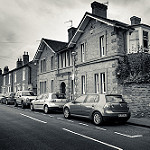

In [29]:
from IPython.display import Image 
Image(filename='data/train/13664.jpg')

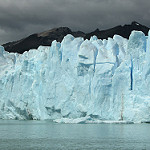

In [30]:
from IPython.display import Image 
Image(filename='data/train/11432.jpg')

In [31]:
os.listdir('data/')

['train', 'test.csv', 'test']

###Loading and Understanding the Data
The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data, means **understanding how the data directories are structured**, what the **labels** are and what some **sample images** look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, **6 labels** are stored based on the csv files.

Fortunately, the fastai library has a handy function made exactly for this.

[Image data from CSV / DataFrame](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_csv).

##Loading Labels [From_CSV](https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L131)

from_csv[source]

from_csv(`path`:PathOrStr, `folder`:PathOrStr=`'.'`, `sep`=`None`, `csv_labels`:PathOrStr=`'labels.csv'`, `valid_pct`:float=`0.2`, `fn_col`:int=`0`, `label_col`:int=`1`, `suffix`:str=`''`, `header`:Union[int, str, NoneType]=`'infer'`, `kwargs`:Any) → ImageDataBunch

Create from a csv file in path/csv_labels.

**data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=24);**




**File Structure**

path\

    labels.csv -> label for training images
    test.csv -> list of test images without labels
    
    train\
      training images
    test\
       testing images
      
 train.csv contains correct labels of **17034 images** in train 
 
 test.csv contains list of **7301 images** in train folder itself but without labels.


In [0]:
tfms = get_transforms()
data = ImageDataBunch.from_csv(path_img, ds_tfms=tfms, size=300)
#data = ImageDataBunch.from_csv(path, train='train','../labels.csv', valid_pct=0.2, ds_tfms=tfms, size=224,classes=[str(i) for i in range(6)])

In [33]:
label_df = pd.read_csv('data/train/labels.csv')
label_df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [34]:
print(data.classes)
len(data.classes),data.c

[0, 1, 2, 3, 4, 5]


(6, 6)

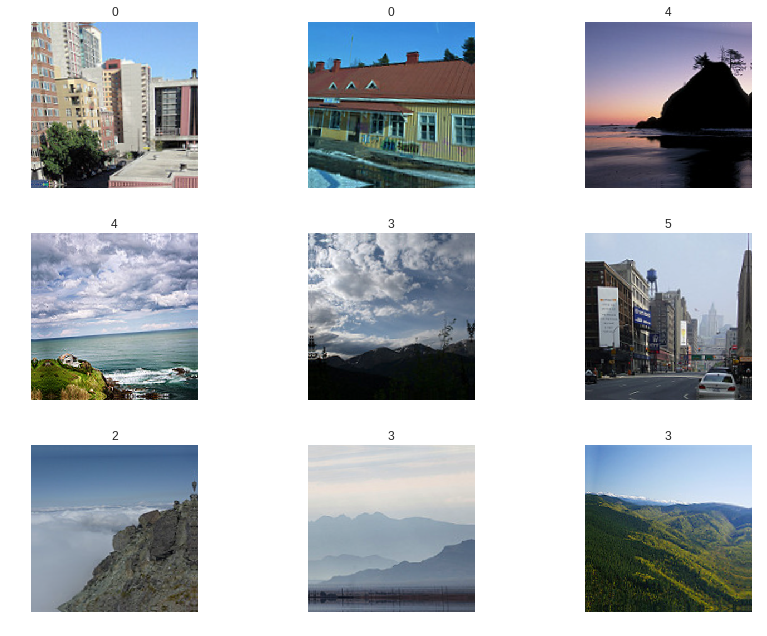

In [35]:
data.show_batch(rows=3, figsize=(12,9))

# Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
#For Metrics to have Top 3 results
from fastai import *
from sklearn import metrics as skm

In [37]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 22271422.52it/s]


epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


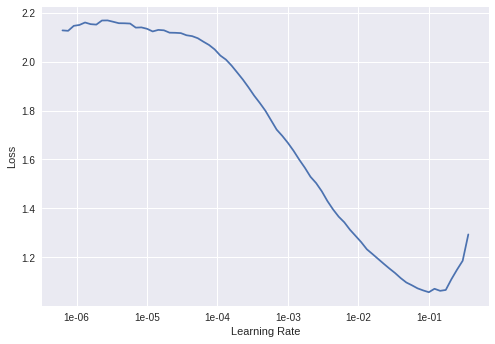

In [38]:
learn.lr_find()
learn.recorder.plot()

##Train and save the model checkpoint

In [33]:
#Run this when training
learn.fit_one_cycle(5) ## best way to fit as of 2018
print("learning complete")

epoch,train_loss,valid_loss,accuracy
1,0.347193,0.236438,0.918086
2,0.276910,0.207897,0.923664
3,0.224855,0.168300,0.941867
4,0.195582,0.156497,0.945978
5,0.158618,0.151934,0.948033


learning complete


In [34]:
print("we save after 1st weights are learned")
learn.save('stage-1-550')


we save after 1st weights are learned


Let's see if full fine-tuning helps:

In [35]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.163372,0.148952,0.948033
2,0.143162,0.144714,0.949501


In [37]:
learn.save('stage-2-9495')
#learn.load('stage-2-9495')

print("we save after 2nd weights are learned")

we save after 2nd weights are learned


In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

If it doesn't, you can always go back to your previous model.

In [39]:
learn.save('stage-3-9527')
#learn.load('stage-3-9527')

print("we save after unfreezing 3rd weights are learned")

we save after unfreezing 3rd weights are learned


In [0]:
print("weights loaded")
#Load the pre-trained model weights
#!mv stage-3-9527.pth data/train/models/stage-3-9527.pth
#!mv stage-2-550.pth data/train/models/stage-2-550.pth
learn.load('stage-3-9527')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

The categories of natural scenes and their corresponding labels in the dataset are as follows -

**'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5**

## New Section

**interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability**

"\nThe categories of natural scenes and their corresponding labels in the dataset are as follows -\n'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5"

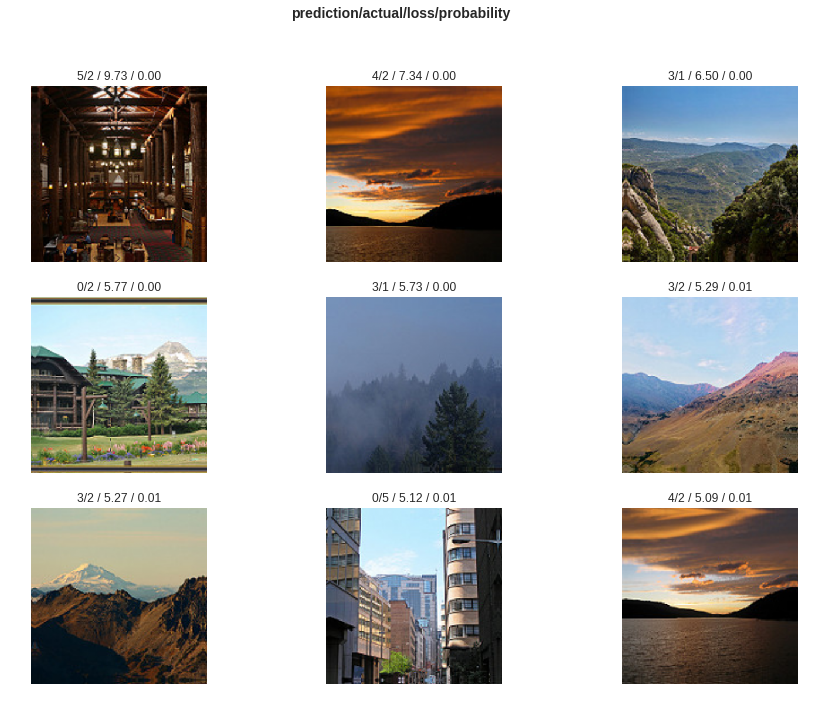

In [45]:
interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability
'''
The categories of natural scenes and their corresponding labels in the dataset are as follows -
'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5'''

In [43]:
interp.most_confused()

[(2, 3, 48),
 (3, 2, 34),
 (0, 5, 26),
 (5, 0, 16),
 (2, 4, 8),
 (3, 4, 6),
 (2, 0, 4),
 (4, 2, 4),
 (1, 3, 3),
 (4, 0, 2)]

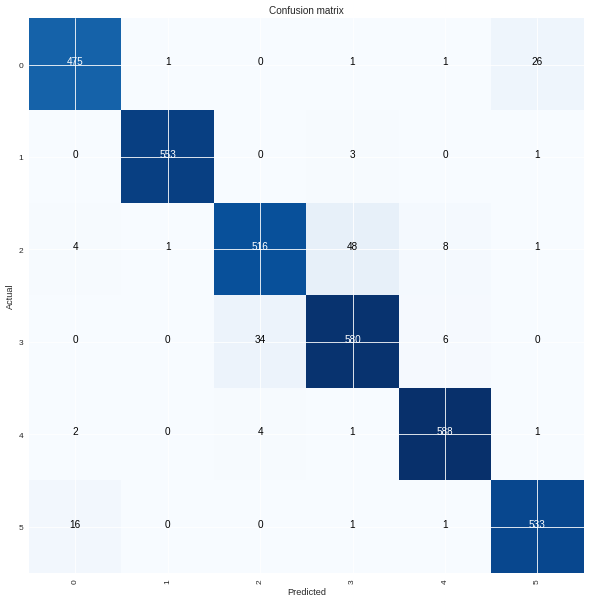

In [44]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)



```
# This is formatted as code
```



---



## Add the Test Folder

In [0]:
# now replace the validation dataset entry with the test dataset as a new validation dataset: 
# everything is exactly the same, except replacing `split_by_pct` w/ `split_by_folder` 
# (or perhaps you were already using the latter, so simply switch to valid='test')
data_test = (ImageItemList.from_csv(path_img,csv_name='labels.csv')
        .split_by_folder(train='train', valid='../test')
        .label_from_csv()
        .transform(tfms)
        .databunch()
        .normalize()
       ) 
learn.data = data_test
learn.validate()

In [0]:
data = ImageDataBunch.from_csv(path_img, ds_tfms=tfms, size=300)


###Start the Prediction for the Test Dataset based on test csv

In [0]:
#test_files = os.listdir('data/test')
#test_df = pd.read_csv(f'{path}test.csv')
#print("test files are") 
#test_files
#test_file_name = pd.DataFrame(test_files)
print(test_file_name.nunique())


In [0]:
#demo = []
  img = learn.data.test_ds[0][0]
  a = learn.predict(img)
  b = list(a)[2]
  print(a)
  c = pd.DataFrame([[i, b[i]] for i in range(len(b))])
  c.columns = ["class","probability"]
  #print(c)
  d = c.sort_values("probability", ascending = False)
  #demo.append(d[:3])
  #d = sorted(c, reverse = True)
  print(d[:3])

#??learn.predict

In [0]:
preds,_ = learn.get_preds(DatasetType.Test);

In [0]:
pred,y = learn.TTA(DatasetType.Test);

In [0]:
# Predict into the test set
learn.get_preds(DatasetType.Test)
test_output = learn.get_preds(is_test=True)
log_probs, y = test_output

In [0]:
DatasetType.Test[0]

In [0]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

data.test_ds.x

test.
#pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)];pred_labels
#df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
#df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)

In [0]:
preds.info()


In [0]:
predsnp = np.array(preds)
predsdf = pd.DataFrame(predsnp)

In [0]:
predsdf

In [0]:
predsdf.to_csv("preds.csv")